# Réduction de dimension

In [1]:
from pickleshare import PickleShareDB
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## Chargement des données

Nous chargeons les données depuis le fichier des données préparées.

In [2]:
db = PickleShareDB('../prep_data/kity')

In [ ]:
# Données nettoyées
# df_net_1 = db['net_attack_1_clean']
# df_net_2 = db['net_attack_2_clean']
df_net_3 = db['net_attack_3_clean']
# df_net_4 = db['net_attack_4_clean']
# df_net_norm = db['net_norm_clean']

In [4]:
# Création d'un dataset avec toutes les données
#df = [db['net_attack_1_clean'], db['net_attack_2_clean'], db['net_attack_3_clean'], db['net_attack_4_clean'], db['net_norm_clean']]
#df = pd.concat(df, axis=0, ignore_index=True)

In [5]:
df = df_net_3.copy()

In [6]:
df.head()

,Time,mac_s,mac_d,ip_s,ip_d,sport,dport,proto,flags,size,modbus_fn,n_pkt_src,n_pkt_dst,modbus_response,label_n,label,is_duplicate
0,2021-04-09 19:42:13.484804,00:80:f4:03:fb:12,74:46:a0:bd:a7:1b,84.3.251.18,84.3.251.20,system_ports,dynamic/private_ports,Modbus,11000,64,Read Coils Response,0,0,0,False,normal,False
1,2021-04-09 19:42:13.487062,74:46:a0:bd:a7:1b,0a:fe:ec:47:74:fb,84.3.251.20,84.3.251.102,dynamic/private_ports,system_ports,Modbus,11000,66,Read Holding Registers,0,0,inconnue,False,normal,False
2,2021-04-09 19:42:13.487078,74:46:a0:bd:a7:1b,fa:00:bc:90:d7:fa,84.3.251.20,84.3.251.103,dynamic/private_ports,system_ports,Modbus,11000,66,Read Holding Registers,1,0,inconnue,False,normal,False
3,2021-04-09 19:42:13.487079,74:46:a0:bd:a7:1b,00:80:f4:03:fb:12,84.3.251.20,84.3.251.18,dynamic/private_ports,system_ports,Modbus,11000,66,Read Coils Request,2,0,inconnue,False,normal,False
4,2021-04-09 19:42:13.487080,74:46:a0:bd:a7:1b,e6:3f:ac:c9:a8:8c,84.3.251.20,84.3.251.101,dynamic/private_ports,system_ports,Modbus,11000,66,Read Holding Registers,3,0,inconnue,False,normal,False


In [7]:
print(f"{df[['label', 'label_n']].value_counts()}")

label           label_n
DoS             True       3076441
normal          False      2070555
physical fault  True        344244
MITM            True        252963
anomaly         True            74
Name: count, dtype: int64


## Préparation des données

Avant de réaliser la PCA, nous préparons les données afin qu'elles soient traitées correctement lors de la réduction de dimensions.

La colonne Time, au format datetime, n'étant pas directement interprétable par la PCA, nous la supprimons.

Nous avions initialement généré des colonnes dérivées de Time telles que le jour, le mois, l'année, l'heure, la minute, la seconde, la microseconde et le delta de temps. Cependant, cette approche n'a pas donné de résultats pertinents : la PCA révélait principalement un alignement des points en fonction de la dimension temporelle, ce qui ne contribuait pas à l'analyse globale.

In [8]:
df = df.drop(columns=['Time'])

Nous normalisons les colonnes au format numérique afin qu'elles contribuent équitablement à la PCA et évitent qu'une variable domine les résultats.

In [9]:
scaler = StandardScaler()
df[['n_pkt_src', 'n_pkt_dst', 'size']] = scaler.fit_transform(df[['n_pkt_src', 'n_pkt_dst', 'size']])

Nous supprimons les colonnes label et label_n pour éviter qu'elles influencent la PCA, car ce sont les variables cibles et non pas des caractéristiques.  
Mais nous les conservons pour pouvoir les rajouter plus tard dans l'analyse et la visualisation.

In [10]:
labels = df[['label', 'label_n']]
df = df.drop(columns=['label', 'label_n'])

Pour les colonnes catégorielles avec peu de valeurs différentes, nous avons réalisé un One-Hot afin de transformer leurs catégories en variables binaires.  
Cela permet à la PCA de traiter correctement ces colonnes non numériques, en concervant les valeurs des catégories.

In [11]:
df = pd.get_dummies(df, columns=['flags',  'proto', 'modbus_fn', 'modbus_response', 'dport', 'sport',], prefix=['flags', 'proto', 'modbus_fn', 'modbus_response', 'dport', 'sport',])

Pour les colonnes de type object, nous avons appliqué un encodage ordinal pour convertir les catégories en valeurs numériques, afin qu'elles soient exploitables dans la PCA.
Puis nous les standardisons pour qu'elles aient le même poids que les autres colonnes numériques.

In [12]:
ordinal_encoder = OrdinalEncoder()
df[['ip_s', 'ip_d', 'mac_s', 'mac_d']] = ordinal_encoder.fit_transform(df[['ip_s', 'ip_d', 'mac_s', 'mac_d']])
scaler = StandardScaler()
df[['ip_s', 'ip_d', 'mac_s', 'mac_d']] = scaler.fit_transform(df[['ip_s', 'ip_d', 'mac_s', 'mac_d']])

Nous supprimons les colonnes créée à cause des valeurs manquantes, car elles n'ont pas d'utilitées.

In [13]:
df.drop(columns=['modbus_fn_inconnue', 'flags_inconnue',  'modbus_response_inconnue'], inplace=True) #'sport_inconnu', 'dport_inconnu',

Nous transformons les valeurs booléennes en float afin qu'elles soient traitées correctement dans la PCA.

In [14]:
for col in df.columns:
    if df[col].dtype == 'bool':
        df[col] = df[col].astype(float)

### Vérification

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5744277 entries, 0 to 5862546
Data columns (total 39 columns):
 #   Column                                     Dtype  
---  ------                                     -----  
 0   mac_s                                      float64
 1   mac_d                                      float64
 2   ip_s                                       float64
 3   ip_d                                       float64
 4   size                                       float64
 5   n_pkt_src                                  float64
 6   n_pkt_dst                                  float64
 7   is_duplicate                               float64
 8   flags_10                                   float64
 9   flags_100                                  float64
 10  flags_10000                                float64
 11  flags_10001                                float64
 12  flags_10010                                float64
 13  flags_10100                                floa

Notre dataset ne contient plus que des colonnes numériques exploitables par la PCA.

In [16]:
df.head()

,mac_s,mac_d,ip_s,ip_d,size,n_pkt_src,n_pkt_dst,is_duplicate,flags_10,flags_100,...,modbus_response_4000,modbus_response_autre,dport_dynamic/private_ports,dport_inconnu,dport_system_ports,dport_user_ports,sport_dynamic/private_ports,sport_inconnu,sport_system_ports,sport_user_ports
0,-0.430164,0.810288,0.616339,0.808220,-0.964157,-1.783903,-1.7853,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.923207,-0.314441,1.075654,-1.790910,-0.961390,-1.783903,-1.7853,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.923207,1.935017,1.075654,-1.357721,-0.961390,-1.756007,-1.7853,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.923207,-0.876806,1.075654,0.375032,-0.961390,-1.728111,-1.7853,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.923207,1.372652,1.075654,-2.224098,-0.961390,-1.700215,-1.7853,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


## Réduction de dimensions : PCA

### Variance expliquée par les dimensions

In [17]:
pca = pca = PCA()
df_pca = pca.fit(df)

In [18]:
variance_expliquee = (pca.explained_variance_ratio_ * 100).round(2)
#variance_expliquee = variance_expliquee.round(2)

variance_table = pd.DataFrame({
    "Composante": [f"PC{i+1}" for i in range(len(variance_expliquee))],
    "Pourcentage de Variance Expliquée": variance_expliquee,
    "Total": variance_expliquee.cumsum()
})

print(variance_table)

   Composante  Pourcentage de Variance Expliquée  Total
0         PC1                              61.03  61.03
1         PC2                              24.81  85.84
2         PC3                               3.91  89.75
3         PC4                               2.23  91.98
4         PC5                               1.68  93.66
5         PC6                               1.34  95.00
6         PC7                               1.18  96.18
7         PC8                               0.91  97.09
8         PC9                               0.68  97.77
9        PC10                               0.57  98.34
10       PC11                               0.50  98.84
11       PC12                               0.21  99.05
12       PC13                               0.21  99.26
13       PC14                               0.19  99.45
14       PC15                               0.14  99.59
15       PC16                               0.10  99.69
16       PC17                               0.09

Le nombre de dimensions minimum permettant de conserver au moins 90% de l'information :
- df_1 : 6 dimensions (PC6  2.65  91.94)
- df_2 : 6 dimensions (PC6  2.26  91.29)
- df_3 : 4 dimensions (PC4  2.33  91.95)
- df_4 : 6 dimensions (PC6  2.62  90.53)
- df_norm : pas d'interêt
- all : 6 dimensions (PC6  2.22  91.00)

In [19]:
db['pca_variance_table'] = variance_table

### Features importants par dimensions

In [20]:
# Poids features par dimension
pca_components = pd.DataFrame(pca.components_, columns=df.columns, index=[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))])

print("Contribution des features à chaque composante principale :")
print(pca_components)

Contribution des features à chaque composante principale :
             mac_s         mac_d          ip_s          ip_d          size  \
PC1  -3.779614e-01 -3.523049e-01  7.511619e-02  1.813981e-01  3.951374e-01   
PC2  -4.188656e-02  8.579374e-03  5.996953e-01 -5.413964e-01  1.536779e-02   
PC3  -3.520594e-01  7.438542e-01  2.745245e-01  1.875030e-01 -2.334207e-01   
PC4  -1.629316e-01 -4.610335e-01  4.755453e-01  4.895353e-01 -3.297677e-01   
PC5   6.177390e-01  3.801155e-02  1.010891e-01  3.181669e-01 -1.201586e-01   
PC6  -4.792333e-01 -9.621998e-02 -5.651544e-02 -9.245449e-02 -9.814417e-02   
PC7  -4.590103e-02  1.268943e-01 -8.444756e-02 -6.344475e-02  8.763288e-02   
PC8   3.692999e-02  1.755069e-01  3.541684e-01  1.915204e-01  4.221580e-01   
PC9  -9.004756e-02 -8.745836e-02 -1.660371e-01 -1.180132e-01 -1.555461e-01   
PC10  1.749842e-01 -2.002952e-01  2.641003e-01 -4.631277e-01 -1.108451e-01   
PC11  2.243116e-01  4.911119e-02  2.720706e-01  6.104716e-02  1.376661e-01   
PC12 

In [21]:
# Affichage des features les plus importants pour chaque composante
pca_components = pd.DataFrame(pca.components_, columns=df.columns, index=[f'PC{i+1}' for i in range(len(pca.components_))])

top_features = {}
for pc in ['PC1', 'PC2', 'PC3']:
    top_features[pc] = pca_components.loc[pc].abs().nlargest(5).index.tolist()

for pc, features in top_features.items():
    print(f"{pc} : {', '.join(features)}")

PC1 : size, n_pkt_dst, mac_s, n_pkt_src, mac_d
PC2 : ip_s, ip_d, n_pkt_src, dport_dynamic/private_ports, sport_system_ports
PC3 : mac_d, mac_s, ip_s, size, n_pkt_dst


### Visualisation des résultats

#### 2 premières dimensions de la PCA

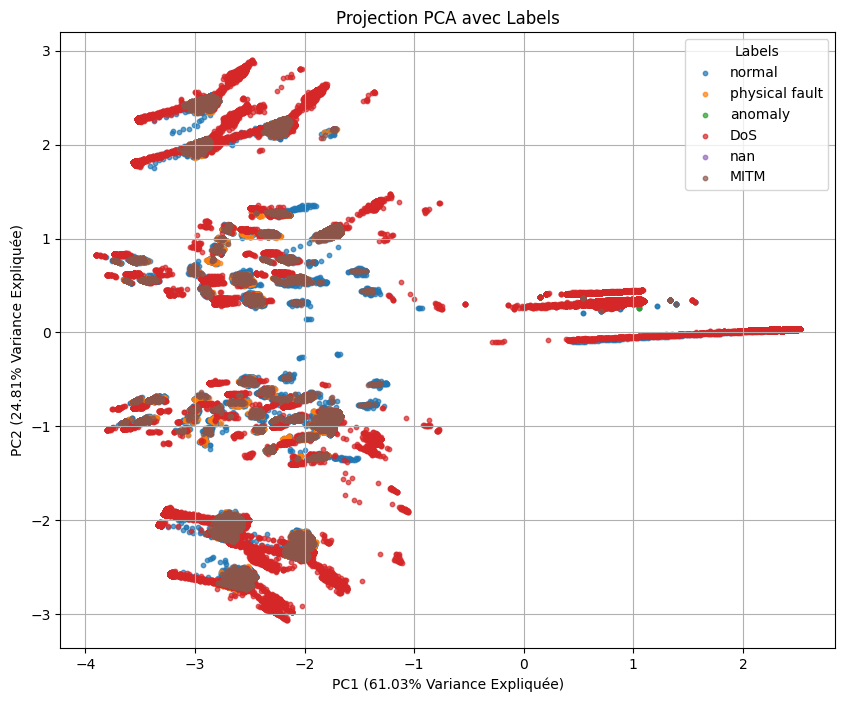

In [22]:
pca = PCA(n_components=2)
df_pca_2d = pca.fit_transform(df)

df_pca_with_labels = pd.DataFrame(df_pca_2d, columns=["PC1", "PC2"])
df_pca_with_labels["label"] = labels["label"] # ajout des labels

plt.figure(figsize=(10, 8))
for label in df_pca_with_labels["label"].unique():
    subset = df_pca_with_labels[df_pca_with_labels["label"] == label]
    plt.scatter(subset["PC1"], subset["PC2"], label=label, alpha=0.7, s=10)
plt.xlabel("PC1 (%.2f%% Variance Expliquée)" % (pca.explained_variance_ratio_[0] * 100))
plt.ylabel("PC2 (%.2f%% Variance Expliquée)" % (pca.explained_variance_ratio_[1] * 100))
plt.title("Projection PCA avec Labels")
plt.legend(title="Labels", loc="best")
plt.grid(True)
plt.show()

#### 3 premières dimensions de la PCA

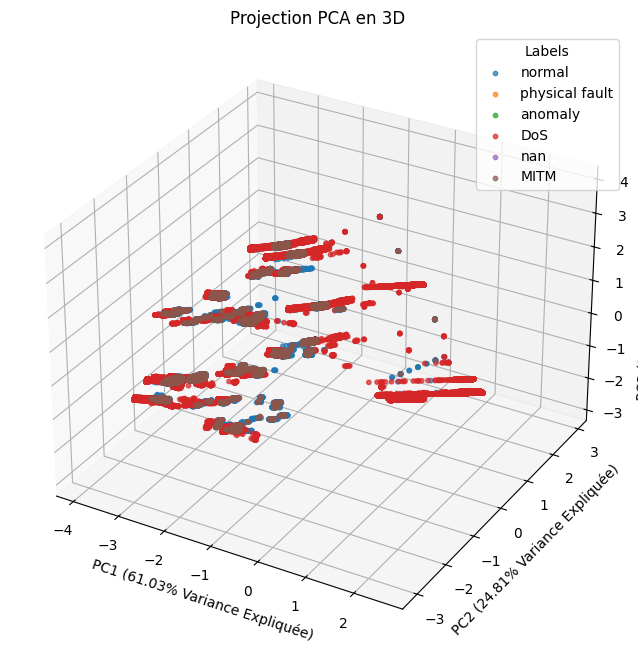

In [23]:
pca = PCA(n_components=3)
df_pca_3d = pca.fit_transform(df)

df_pca_with_labels = pd.DataFrame(df_pca_3d, columns=["PC1", "PC2", "PC3"])
df_pca_with_labels["label"] = labels["label"]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for label in df_pca_with_labels["label"].unique():
    subset = df_pca_with_labels[df_pca_with_labels["label"] == label]
    ax.scatter(subset["PC1"], subset["PC2"], subset["PC3"], label=label, alpha=0.7, s=10)

ax.set_xlabel("PC1 (%.2f%% Variance Expliquée)" % (pca.explained_variance_ratio_[0] * 100))
ax.set_ylabel("PC2 (%.2f%% Variance Expliquée)" % (pca.explained_variance_ratio_[1] * 100))
ax.set_zlabel("PC3 (%.2f%% Variance Expliquée)" % (pca.explained_variance_ratio_[2] * 100))
ax.set_title("Projection PCA en 3D")
ax.legend(title="Labels", loc="best")
plt.show()

La réduction de dimension par PCA permet de réduire le nombre de colonnes dans les datasets tout en concervant une grande partie de l'information.  
Nous allons utiliser ces résultats dans nos modèles afin de réduire la taille des données tout en gardant un maximum d'information.

## Enregistrement données

In [24]:
# Calcul de la PCA et transformation en df
pca = PCA(n_components=7) 
df_pca = pca.fit_transform(df)

df_pca_result = pd.DataFrame(df_pca, columns=[f'PC{i+1}' for i in range(df_pca.shape[1])])

In [25]:
# Enregistrement sans les labels
db['pca_result_no_label'] = df_pca_result

In [26]:
print(df_pca_result.head())

        PC1       PC2       PC3       PC4       PC5       PC6       PC7
0 -2.334774 -0.829691  0.805247  1.669524 -1.421805  0.153835 -0.028546
1 -2.853239  2.025406 -1.193658  0.614723 -0.623709  0.424677 -0.762122
2 -3.556715  1.816421  0.563395 -0.214209 -0.391482  0.162492 -0.504071
3 -2.232421  0.840246 -1.239604  2.161127  0.210541  0.299646  0.406347
4 -3.494871  2.293135 -0.012252 -0.386899 -0.670722  0.285319 -0.520283


In [27]:
# Enregistrement avec les labels
df_pca_result_with_labels = pd.concat([df_pca_result, labels.reset_index(drop=True)], axis=1)
db['pca_result_with_labels'] = df_pca_result_with_labels

In [28]:
print(df_pca_result_with_labels.head())

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -2.334774 -0.829691  0.805247  1.669524 -1.421805  0.153835 -0.028546   
1 -2.853239  2.025406 -1.193658  0.614723 -0.623709  0.424677 -0.762122   
2 -3.556715  1.816421  0.563395 -0.214209 -0.391482  0.162492 -0.504071   
3 -2.232421  0.840246 -1.239604  2.161127  0.210541  0.299646  0.406347   
4 -3.494871  2.293135 -0.012252 -0.386899 -0.670722  0.285319 -0.520283   

    label  label_n  
0  normal    False  
1  normal    False  
2  normal    False  
3  normal    False  
4  normal    False  
